<h1>MNIST</h1>

MNIST is a set of 70.000 handwritten small images of digits. Each image is labeled with the digit it represents.
<br>
The dataset is already split into training set (first 60.000 images) and test set (last 10.000 images)
<br>
Each image has 784 features -> 28x28 pixels. Each feature represents one pixel's intensity - from 0 to 255 (white to black)

### Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

### Import dataset

In [2]:
from sklearn.datasets import fetch_mldata #where MNIST dataset resides

mnist_data = fetch_mldata(dataname="MNIST original")

### Parse dataset
Parse the dataset into set with features and set with labels.

In [3]:
def parse_data(mnist_data):
    return mnist_data["data"], mnist_data["target"]

### MNIST details

In [4]:
print("Type:", type(mnist_data))
print("Description:", mnist_data.DESCR)
X, y = parse_data(mnist_data=mnist_data)
print("Shape of features:", X.shape)
print("Shape of labels:", y.shape)
print("Datatype of features:", type(X))
print("Datatype of labels:", type(y))

Type: <class 'sklearn.utils.Bunch'>
Description: mldata.org dataset: mnist-original
Shape of features: (70000, 784)
Shape of labels: (70000,)
Datatype of features: <class 'numpy.ndarray'>
Datatype of labels: <class 'numpy.ndarray'>


### Get training and test datasets

In [5]:
# training set
shuffle_index = np.random.permutation(60000)
X_train = X[:60000]
y_train = y[:60000]
X_train = X_train[shuffle_index]
y_train = y_train[shuffle_index]

#test set
X_test, y_test = X[60000:], y[60000:]

### Show random digit

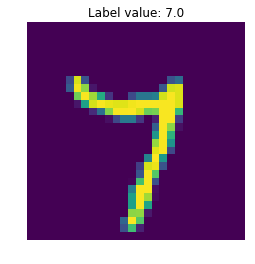

In [6]:
def show_digit(index=np.random.randint(60000)):
    image_index = index
    random_digit = X_train[image_index]
    random_digit_image = random_digit.reshape(28, 28)
    plt.imshow(random_digit_image)
    plt.axis("off")
    plt.title("Label value: " + str(y_train[image_index]))
    plt.show()
    
show_digit()

### Is digit 5 or not?

In [7]:
y_train_5 = (y_train == 5) # True if 5, False if otherwise
y_test_5 = (y_test == 5)

# Classifiers
<br>
Stohastic Gradient Descent classifier

## Train

In [8]:
from sklearn.linear_model import SGDClassifier
import warnings # suppress FutureWarnings

warnings.simplefilter(action='ignore', category=FutureWarning)
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X=X_train, y=y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

## Predict

In [9]:
y_pred = sgd_clf.predict(X_train)
print(y_pred)

[False False False ..., False False False]


# Performance Measures
<br>
## Cross Validation
<br>
K-fold cross-validation: splitting the training set into K-folds, making predictions and evaluating them on each fold using model trained on REMAINING folds

In [10]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.base import clone

l_cvs = []
skfolds = StratifiedKFold(n_splits=3, random_state=42)
# Folds have size trunc(n_samples / n_splits)
for train_index, test_index in skfolds.split(X=X_train, y=y_train):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]

    clone_clf.fit(X=X_train_folds, y=y_train_folds)
    y_pred_x_val = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred_x_val == y_test_fold)
    cvs = n_correct / len(y_pred_x_val)
    l_cvs.append(cvs)
l_cvs = [ '%.3f' % elem for elem in l_cvs]
print(l_cvs)

['0.097', '0.097', '0.098']


## Cross Validation score with function from scikit learn

In [11]:
cvs = cross_val_score(estimator=sgd_clf, X=X_train, y=y_train, cv=3, scoring="accuracy")
print(cvs)

[ 0.86082783  0.87174359  0.86017903]


## Test with stupid classifier
<br>
All digits are classified as not 5.
<br>
10% of images are not 5 so guessing an image is not 5 will make it right about 90% of the time.

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
        
never_5_clf = Never5Classifier()
cvs_never_5 = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(cvs_never_5)

[ 0.90725  0.91195  0.90975]


## Confusion Matrix
<br>
Better way to evaluate performance of a classifier.
<br>
For example: How many times is an image labeled 5 is confused with an image labeled 3.

| |Predicted Negative|Predicted Positive|
|-| ------------- |-------------|
|<b>Actual Negative</b>|True Negative|False Positive|
|<b>Actual Positive</b>|False Negative|True Positive|

In [13]:
# confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, cv=3) #
conf_matrix = confusion_matrix(y_train_5, y_train_pred)
print(conf_matrix)
print("First row are non-5 images (negative class)")
print("\tTrue negatives (correctly classified as non-5):", conf_matrix[0][0])
print("\tFalse positives (wrongly classified as 5):", conf_matrix[0][1])
print("Second row are 5 images (positive class)")
print("\tFalse negatives (wrongly classified as non-5):", conf_matrix[1][0])
print("\tTrue positives (correctly classified as 5):", conf_matrix[1][1])

[[53538  1041]
 [ 1409  4012]]
First row are non-5 images (negative class)
	True negatives (correctly classified as non-5): 53538
	False positives (wrongly classified as 5): 1041
Second row are 5 images (positive class)
	False negatives (wrongly classified as non-5): 1409
	True positives (correctly classified as 5): 4012


## Precision and Recall
<br>
Recall - sensitivity or true positive rate (TPR)

In [14]:
from sklearn.metrics import precision_score, recall_score

precision = round(precision_score(y_true=y_train_5, y_pred=y_train_pred), 3)
recall = round(recall_score(y_true=y_train_5, y_pred=y_train_pred), 3)
print("Model claims an image representing 5 is correct in", round(precision, 3))
print("Model detects only", round(recall, 3), "of the 5s")

Model claims an image representing 5 is correct in 0.794
Model detects only 0.74 of the 5s


## Formulas for Precision and Recall
<br>
### Precision:
$\frac{TP}{TP+FP}$
<br>
<br>
### Recall:
$\frac{TP}{TP+FN}$

In [15]:
precision_formula = round(conf_matrix[1][1]/(conf_matrix[1][1] + conf_matrix[0][1]), 3)
recall_formula = round(conf_matrix[1][1]/(conf_matrix[1][1] + conf_matrix[1][0]), 3)
print("Precision formula:", precision_formula)
print("Recall formula:", recall_formula)

Precision formula: 0.794
Recall formula: 0.74


## $F_{1}$ score
<br>
$F_{1}$ score is a harmonic mean of precision and recall. Harmonic mean gives more weight to low values.
<br>High $F_{1}$ score is expected only if both precision and recall are high. It favours classifiers that have similar precision and recall
<br><br>
$F_{1}$ = 2 x $\frac{precision\cdot recall}{precision + recall}$ = $\frac{TP}{TP + \frac{FN+FP}{2}}$

In [16]:
from sklearn.metrics import f1_score
f1 = f1_score(y_train_5, y_train_pred)
print(f1)

0.76608745465


## Precision/Recall Tradeoff

In [17]:
y_scores = sgd_clf.decision_function([X_train[36000]]) # returns a score for each instance
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[-347836.32111201]
[False]


SGDClassifier uses a threshold equal to 0, so the previous code returns the same result as predict().
Below code experiemtns with raised threshold:

In [18]:
threshold = -200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


Compute precision and recall for all possible threshold

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")[:,1]

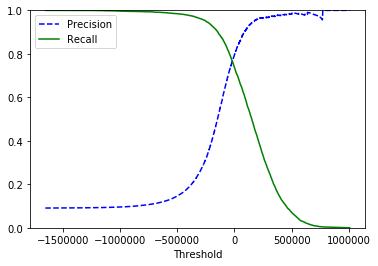

In [20]:
from sklearn.metrics import precision_recall_curve

#print(y_train_5.shape, y_scores.shape)
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

### Precision versus Recall

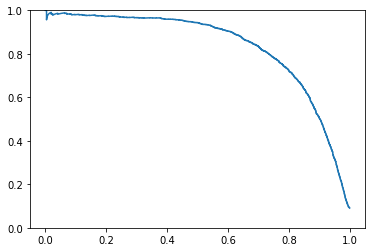

In [21]:
plt.plot(recalls, precisions) 
plt.ylim([0, 1])
plt.show()

#### Aiming for 90% precision
From the first plot, 90% precision is at about 120.000.

In [22]:
y_train_pred_90 = (y_scores > 120000)
precision_90 = precision_score(y_train_5, y_train_pred_90)
print(precision_90)
recall_90 = recall_score(y_train_5, y_train_pred_90)
print(recall_90)

0.925030978934
0.550820881756


<span style="color:red">A high precision classifier is not very useful if its recall is too low!</span>

## The ROC Curve
The Receiver Operating Characteristic is a tool used with binary classifiers.
<br>
The ROC curve plots <i>true positive rate</i> (TPR or recall) against <i>false positive rate</i> (FPR). The FPR is the ratio of negative instances that are incorreectly classified as positive.

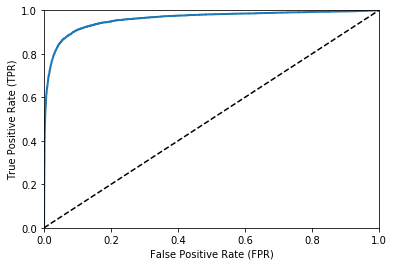

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
plot_roc_curve(fpr, tpr)

ROC curve plots sensitivity (recall) versus 1-specificity.
<br>
Again, there is a tradeoff - the higher the recall (TPR), the more false positives the classifier produces.

### Area under the curve (AUC)
A perfect classifier will have a ROC AUC = 1. Purely random classifier will have ROC AUC = 1

In [24]:
from sklearn.metrics import roc_auc_score

roc = roc_auc_score(y_true=y_train_5, y_score=y_scores)
print(roc)

0.96044038309


# Multiclass Classification

(aka Multinomial Classifiers) can distinguish between more than two classes.
<br>
Random Forest, Logistic Regression, KNN or naive Bayes classifiers are <b>directly</b> multi-class classifiers. SVM, Perceptron, Boosting or Linear classifiers are strictly binary classifiers.

Scikit-Learn <b>automatically runs One-versus-All (OvA)</b> when binary classification algorithm is used for multi-class classification. Excpetion is only SVM where OvO is used.


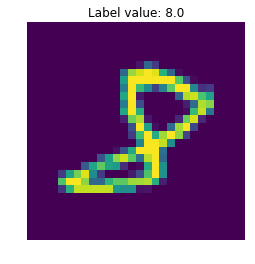

In [25]:
image_index = 36000
sgd_clf.fit(X_train, y_train)
pred = sgd_clf.predict([X_train[image_index]])
show_digit(index=image_index)

Scikit-Learn trained 10 binary classifiers, got their decision scores and selected the one with the highest score.

In [26]:
image_index_scores = sgd_clf.decision_function([X_train[image_index]])
print(image_index_scores)
print("Index with highest score:", np.argmax(image_index_scores))

[[-386773.24011789 -480331.33360094  -10902.31234292 -384711.77270364
  -722793.5643849  -347836.32111201 -639983.82643648 -518414.14575833
    -2042.3530303   -74933.13753038]]
Index with highest score: 8


### Force Scikit-Learn to use OvO

In [27]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X=X_train, y=y_train)
ovo_pred = ovo_clf.predict([X_train[image_index]])
print(ovo_pred)
print("Amount of estimators compared to each other:", len(ovo_clf.estimators_))

[ 8.]
Amount of estimators compared to each other: 45


### Using Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X=X_train, y=y_train)
forest_pred = forest_clf.predict([X_train[image_index]])
print(forest_pred)
forest_proba = forest_clf.predict_proba([X_train[image_index]])
print("List of probabilites for each class:", forest_proba)

[ 8.]
List of probabilites for each class: [[ 0.   0.   0.   0.   0.   0.   0.   0.1  0.9  0. ]]


### Evaluate Classifiers using cross-validation

In [29]:
multiple_cross_validation_score = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
print(multiple_cross_validation_score)

[ 0.86082783  0.87174359  0.86017903]


Random classifier would get you around 10%.

#### Scaling the inputs
Can we improve scores above?

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # transformer
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
multiple_scaled_cross_validation_score = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
print(multiple_scaled_cross_validation_score)

[ 0.91256749  0.90754538  0.90878632]


# Error Analysis
How to improve the model

### Confusion metrix

In [31]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5731    2   14   11   11   51   51    8   40    4]
 [   1 6475   43   26    6   38   12   13  116   12]
 [  54   31 5309  102   89   24  105   51  179   14]
 [  50   41  132 5348    2  231   33   55  144   95]
 [  23   27   39    9 5372   11   52   33   76  200]
 [  72   42   30  187   75 4597  120   28  184   86]
 [  30   22   48    3   43   86 5629    7   50    0]
 [  25   21   75   29   55   11    7 5793   18  231]
 [  52  141   74  152   13  158   59   25 5054  123]
 [  44   36   30   88  170   32    2  195   82 5270]]


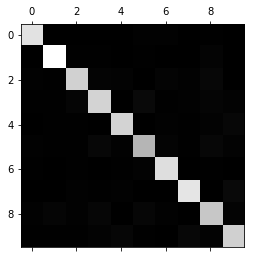

In [32]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

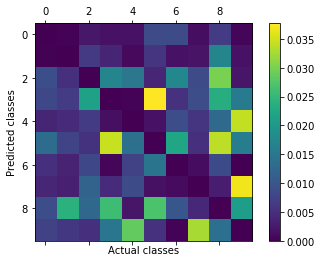

In [33]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
#plt.matshow(norm_conf_mx, cmap=plt.cm.coolwarm, )

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, interpolation='nearest')
fig.colorbar(cax)
plt.xlabel("Actual classes")
plt.ylabel("Predicted classes")

plt.show()

Columns for 8 and 9 seem to have different colors than others, that means many images get misclassified as 8s or 9s.
<br>
3 and 5 also seem to get confused often.

#### Analyzing individual errors

In [34]:
# copid from https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

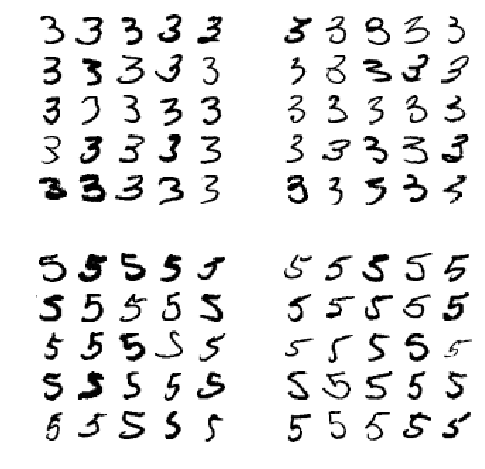

In [35]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

# Multilabel Classification
Outputing multiple classes for each instance

In [36]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
#print(list(zip(y_train, y_multilabel))[:11])

knn_clf = KNeighborsClassifier()
knn_clf.fit(X=X_train, y=y_multilabel)

print("Testing for digit:", y_train[36000])
knn_pred = knn_clf.predict([X_train[36000]])
print("Prediction", knn_pred)

Testing for digit: 8.0
Prediction [[ True False]]


### Evaluate Multilabel Classification
#### Average $F_{1}$ score across all labels

In [37]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1 = f1_score(y_train, y_train_knn_pred, average="macro")
print(f1)

0.967959983542


### Multioutput Classification
Each label can be multiclass.
<br>
The example below, each label can have multiple values (pixel value ranges from 0 to 255)

#### Removing noise from images

In [38]:
# Adding random noise to images
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

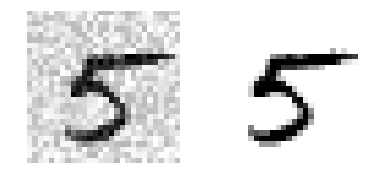

In [39]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary, interpolation="nearest")
    plt.axis("off")


some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

#### Clean the image

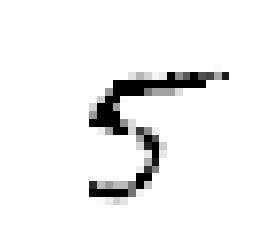

In [40]:
knn_clf.fit(X=X_train_mod, y=y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)